# IRMDP: Homework 6.2 and 6.3

Implementation is according to [testSensitivity.py](https://github.com/sschlenkrich/QuantLibPython/blob/master/testSensitivity.py).

## Importing of classes and necessary setting as in testSensitivity.py

In [1]:
import sys, os, io, copy, time
if locals().get('__file__'):
    sys.path.append(os.path.join(os.path.dirname(__file__),'QuantLibWrapper'))
else:
    sys.path.append(os.path.join(os.getcwd(),'QuantLibWrapper'))
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from itertools import product

import QuantLib as ql

from QuantLibWrapper import YieldCurve, Swap, Swaption, createSwaption, \
    HullWhiteModel, HullWhiteModelFromSwaption, BermudanSwaption, PDESolver, \
    DensityIntegrationWithBreakEven, CubicSplineExactIntegration, \
    SimpsonIntegration, HermiteIntegration
from QuantLibWrapper.YieldCurve import YieldCurve

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
terms = [    '1y',    '2y',    '3y',    '4y',    '5y',    '6y',    '7y',    '8y',    '9y',   '10y',   '12y',   '15y',   '20y',   '25y',   '30y' ] 
rates = [ 2.70e-2, 2.75e-2, 2.80e-2, 3.00e-2, 3.36e-2, 3.68e-2, 3.97e-2, 4.24e-2, 4.50e-2, 4.75e-2, 4.75e-2, 4.70e-2, 4.50e-2, 4.30e-2, 4.30e-2 ] 

if False:
    terms = [ '30y'   ]  # flat curve
    rates = [ 5.00e-2 ] 
rates2 = [ r+0.005 for r in rates ]

discCurve = YieldCurve(terms,rates)
projCurve = YieldCurve(terms,rates)

a = 0.03 # mean reversion
vol = 0.01
h = 1.0e-12

swaptionStrike = createSwaption('10y','10y',discCurve,projCurve).fairRate() \
                 + vol * np.sqrt(10.0) * np.sqrt(3.0)
swaptionStrike = 0.1048
print('swaptionStrike = ' + str(swaptionStrike))

swaptionStrike = 0.1048


## Computation

In [3]:
test = False
def compute_integration2(method,n_grid_points=101,lambda_std_devs=5,hs=[10.0**(-k) for k in range(3,18)],
                         break_even=False,degree=2,theta=0.5,timeStepSize=1.0/12.0, lambda0N=None):
    if test:
        method = SimpsonIntegration
        n_grid_points=101
        lambda_std_devs=5
        hs = [10**(-10) for i in range(2,18)]
        break_even=[False,True]
        degree=2
        theta=0.5
        timeStepSize=1.0/12.0
        lambda0N=None

    res = []
    assert method in [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration,PDESolver], 'the method is not allowed'
    for h in hs:
        # swaptions
        s0 = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol)
        sp = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol+h)
        sm = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol-h)
        # Hull White model for price evaluation
        h0 = HullWhiteModelFromSwaption(s0,a)
        hp = HullWhiteModelFromSwaption(sp,a)
        hm = HullWhiteModelFromSwaption(sm,a)
        # Evaluation of Bermuda option via density integration
        ## preparing arguments passed to density integration method
        kwargs = {'nGridPoints':n_grid_points,'stdDevs':lambda_std_devs}
        if method.__name__ == 'HermiteIntegration':
            kwargs.update({'degree':degree})
        elif method.__name__ == 'PDESolver':
            kwargs.update({'theta':theta})
            kwargs.update({'timeStepSize':timeStepSize})
            kwargs.update({'lambda0N':lambda0N})
        ## Pricing via density function with or without considering Break Even.
        if break_even: 
            i10 = BermudanSwaption([s0],a,model=h0,method=DensityIntegrationWithBreakEven(method(hwModel=h0,**kwargs)))
            i1p = BermudanSwaption([sp],a,model=hp,method=DensityIntegrationWithBreakEven(method(hwModel=hp,**kwargs)))
            i1m = BermudanSwaption([sm],a,model=hm,method=DensityIntegrationWithBreakEven(method(hwModel=hm,**kwargs)))
        else:
            i10 = BermudanSwaption([s0],a,model=h0,method=method(hwModel=h0,**kwargs))
            i1p = BermudanSwaption([sp],a,model=hp,method=method(hwModel=hp,**kwargs))
            i1m = BermudanSwaption([sm],a,model=hm,method=method(hwModel=hm,**kwargs))
        # combining numerical results
        res.append([ h, s0.vega(),
            s0.npv(),            sp.npv(),            sm.npv(),
            s0.npvHullWhite(h0), sp.npvHullWhite(hp), sm.npvHullWhite(hm),
            i10.npv(),           i1p.npv(),           i1m.npv()
        ])
    column = [ 'h', 'Vega', 'B0', 'Bp', 'Bm', 'H0', 'Hp', 'Hm','I0','Ip','Im']
    ret = pd.DataFrame(dict(zip(column,np.array(res).T)))
    # Enriching the computed data with the settings
    ret['n_grid_points'] = n_grid_points
    ret['lambda_std_devs'] = lambda_std_devs
    ret['theta'] = theta
    ret['timeStepSize'] = timeStepSize
    ret['density_integration_method'] = method.__name__
    ret['degree'] = degree
    ret['lambda0N'] = lambda0N
    ret['break_even'] = break_even
    return ret

In [4]:
def compute_integration2_multiple(n_grid_points=[101],lambda_std_devs=[5],hs=[10.0**(-k) for k in range(3,18)],
                                  break_even=False,degree=[3],
                                  theta=[0.5],timeStepSize=[1/12],lambda0N=[None],
                                  methods = [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration,PDESolver]):
    """Wrapper for the price evaluation of Bermudan swap option via density integration or PDE
    
    Keyword arguments (If not explicitly written parameters have to be numerics or list of numerics): 
    n_grid_points (int) -- number of grid points, default 101
    lambda_std_devs -- grid size (lambda*std), default 5
    hs -- shift size, default [10.0**(-k) for k in range(3,18)]
    break_even (bool) -- density integration with break even, default False
    degree (int) -- Hermite polynomial degrees, default 3
    theta -- time integration parameter, default 0.5
    timeStepSize -- time step size, default 1/12
    lambda0N -- choice of boundary condition, default None
    methods -- method selection for evaluation, only SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration,PDESolver can be selected, default [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration,PDESolver]
    """
    table = list()
    timetable = []
    # Converting all arguments into list to use all combinations of these
    if not isinstance(n_grid_points,list): n_grid_points = [n_grid_points]
    if not isinstance(lambda_std_devs,list): lambda_std_devs = [lambda_std_devs]
    if not isinstance(break_even,list): break_even = [break_even]
    if not isinstance(degree,list): degree = [degree]
    if not isinstance(theta,list): theta = [theta]
    if not isinstance(timeStepSize,list): timeStepSize = [timeStepSize]
    if not isinstance(lambda0N,list): lambda0N = [lambda0N]
    if not isinstance(hs,list): hs = [hs]
    
    # Computation for SimpsonIntegration and CubicSpliceExactIntegration if demanded
    for method in [i for i in methods if i in [SimpsonIntegration,CubicSplineExactIntegration]]:
        for arg in list(product(n_grid_points,lambda_std_devs,break_even)):
            start = time.time()
            tmp = compute_integration2(
                method=method,
                n_grid_points=arg[0],
                lambda_std_devs=arg[1],
                hs=hs,
                break_even=arg[2]
            )
            end = time.time()
            table.append(tmp)
            timetable.append([method.__name__,None,end-start])
            del tmp
    # Computation for SimpsonIntegration and CubicSpliceExactIntegration if demanded
    if HermiteIntegration in methods:
        for arg in list(product(n_grid_points,lambda_std_devs,break_even,degree)):
            start = time.time()
            tmp = compute_integration2(
                method=HermiteIntegration,
                n_grid_points=arg[0],
                lambda_std_devs=arg[1],
                hs=hs,
                break_even=arg[2],
                degree=arg[3]
            )
            end = time.time()
            table.append(tmp)
            timetable.append(['HermiteIntegration',arg[3],end-start])
            del tmp
    if PDESolver in methods:
        for arg in list(product(n_grid_points,lambda_std_devs,break_even,theta,timeStepSize,lambda0N)):
            start = time.time()
            tmp = compute_integration2(
                method=PDESolver,
                n_grid_points=arg[0],
                lambda_std_devs=arg[1],
                hs=hs,
                break_even=arg[2],
                theta=arg[3],
                timeStepSize=arg[4],
                lambda0N=arg[5]
            )
            end = time.time()
            table.append(tmp)
            timetable.append(['PDESolver',None,end-start])
        del tmp
        
    return pd.concat(table),pd.DataFrame(timetable,columns=['method','degree','comp_time'])

Printing the doc string of a function:

In [5]:
print(compute_integration2_multiple.__doc__)

Wrapper for the price evaluation of Bermudan swap option via density integration or PDE
    
    Keyword arguments (If not explicitly written parameters have to be numerics or list of numerics): 
    n_grid_points (int) -- number of grid points, default 101
    lambda_std_devs -- grid size (lambda*std), default 5
    hs -- shift size, default [10.0**(-k) for k in range(3,18)]
    break_even (bool) -- density integration with break even, default False
    degree (int) -- Hermite polynomial degrees, default 3
    theta -- time integration parameter, default 0.5
    timeStepSize -- time step size, default 1/12
    lambda0N -- choice of boundary condition, default None
    methods -- method selection for evaluation, only SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration,PDESolver can be selected, default [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration,PDESolver]
    


In [6]:
def plotRelativeError(table,id,title=''):
    fig = plt.figure(figsize=(6, 4))
    # upward derivative
    vega = (table[id+'p']-table[id+'0'])/table['h']*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Upward')
    # downward derivative
    vega = (table[id+'0']-table[id+'m'])/table['h']*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Downward')
    # two-sided derivative
    vega = (table[id+'p']-table[id+'m'])/table['h']/2.0*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Two-sided')
    # plot properties
    plt.xlabel('shift size h')
    plt.ylabel('|RelError|')
    plt.title(title)
    plt.ylim(1.0e-11,10.0)
    plt.legend()

In [7]:
def plotRelativeError2(table,leg1,leg2=None,integration_method=['Two-sided','Upward','Downward'],
                       title='',ylim=None,x_axis='h',x_axis_label='shift size h',x_log_scale=True,
                       sensitivity=False):
    """Plotting the relative error of the Bermudan price evaluation (or sensitivity) with one or 2 legends
    
    Keyword arguments:
    table (pandas.DataFrage) -- as returned by compute_integration2_multiple
    leg1 (str) -- first legend variable, needs to be a column name of table
    leg2 (str) -- second legend variable, needs to be a column name of table, default None (means integration_method)
    integration_method -- integration technicque used, subset of ['Two-sided','Upward','Downward'] possible, default if leg2 is None ['Two-sided','Upward','Downward'], else integration_method[0]
    title (str) -- plot title, default ''
    ylim (list of 2 numerics) -- limit of y-axis, default None
    x_axis (str) -- x-axis variable, needs to be column of table, default 'h'
    x_axis_label (str) -- x-axis label, default 'shift size h'
    x_log_scale (bool) -- log scale for x-axis, default True
    sensitivity (bool) -- printing price sensitivities instead of price accuracy, default False
    """
    if isinstance(table,tuple): table = table[0]
    fig = plt.figure(figsize=(6, 4))
    val1 = sorted(set(table[leg1]))
    color_list = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
    colors = dict(zip(val1,color_list[:len(val1)]))

    integration_args = dict(zip(['Upward','Downward','Two-sided'],[['p','0'],['0','m'],['p','m']]))
    if leg2 is None:
        val2 = integration_method
    else:
        if isinstance(integration_method,list) and len(integration_method) != 1:
            integration_method_selected = 'Two-sided'
            print('Multiple integration methods were given, only one can be executed, default: Two-sided')
        else:
            integration_method_selected = integration_method
        val2 = sorted(set(table[leg2]))
    linestyles_list = ['-', '--', ':','-.']
    linestyles = dict(zip(val2,linestyles_list[:len(val2)]))
    leg_values = []
    for i1,l1 in enumerate(val1):
        if table[leg1].dtype is pd.DataFrame(['']).dtypes[0]:
            tmp1 = table.query("{0}=='{1}'".format(leg1,l1))
        else:
            tmp1 = table.query('{0}=={1}'.format(leg1,l1))
        for i2,l2 in enumerate(val2):
            if leg2 is None:
                arg = integration_args[l2]
                tmp2 = copy.deepcopy(tmp1)
            else:
                arg = integration_args[integration_method_selected]
                if tmp1[leg2].dtype is pd.DataFrame(['']).dtypes[0]:
                    tmp2 = tmp1.query("{0}=='{1}'".format(leg2,l2))
                else:
                    tmp2 = tmp1.query('{0}=={1}'.format(leg2,l2))
            if sensitivity:
                vega = (tmp2['I'+arg[0]]-tmp2['I'+arg[1]])/tmp2['h']/2.0*1.0e-4
                relError = abs(vega/tmp2['Vega']-1)
            else:
                relError = abs(tmp2['I'+arg[0]] / tmp2['H'+arg[1]] - 1)
            if x_log_scale:
                leg_values.extend(plt.loglog(tmp2[x_axis],relError,linestyle=linestyles[l2],c=colors[l1],label='%s;%s'%(str(l2),str(l1))))
            else:
                leg_values.extend(plt.semilogy(tmp2[x_axis],relError,linestyle=linestyles[l2],c=colors[l1],label='%s;%s'%(str(l2),str(l1))))
    leg_values1 = [i for i in leg_values if i.get_linestyle() is '-']
    fl = plt.legend(
        leg_values1, [i.get_label().split(';')[1] for i in leg_values1], 
        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = leg1, frameon=False
    )
    ax = plt.gca().add_artist(fl)
    leg_values2 = [i for i in leg_values if i.get_c() == color_list[0]]
    plt.legend(
        leg_values2, [i.get_label().split(';')[0] for i in leg_values2],
        bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0., title = leg2 if leg2 is not None else 'Int method',frameon=False
    )
    plt.xlabel(x_axis_label)
    plt.ylabel('|RelError|')
    if not sensitivity:
        title = 'Price accuracy: ' + title
    else:
        title = 'Sensitivity: ' + title
    plt.title(title)
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])

In [8]:
def range_rel_error(table,id='I'):
    integration_args = dict(zip(['Upward','Downward','Two-sided'],[['p','0'],['0','m'],['p','m']]))
    ret = []
    for k,arg in integration_args.items():
        vega = (table[id+arg[0]]-table[id+arg[1]])/table['h']*1.0e-4
        relError = abs(vega/table['Vega']-1)
        ret.append([min(relError),max(relError)])
    return min(ret)[0],max(ret)[1]


### 6.2 (a) Simpson's method

Plot for different shift sizes h:

In [9]:
%%timeit -r 1
%%capture
table_simpson,_ = compute_integration2_multiple(
    methods=[SimpsonIntegration],
    n_grid_points=101,
    lambda_std_devs=5, 
    hs = [10**(-i) for i in range(3,18)],
    break_even=[False,True]
)

36.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


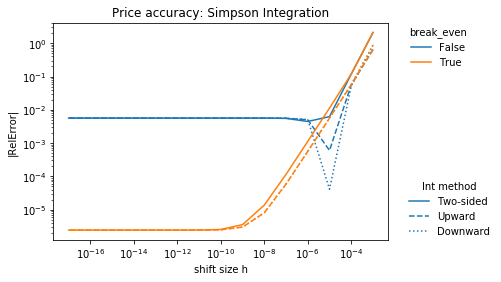

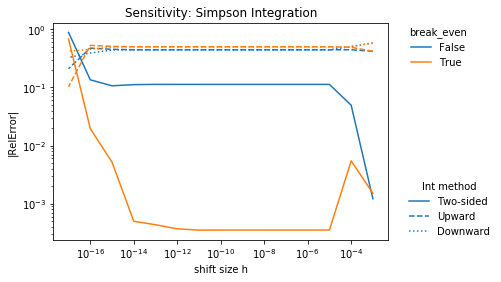

In [10]:
plotRelativeError2(table_simpson,leg1 = 'break_even',title='Simpson Integration')
plotRelativeError2(table_simpson,leg1 = 'break_even',title='Simpson Integration', sensitivity=True)

Plot for different number of grid points:

In [11]:
%%timeit -r 1
%%capture
table_simpson = compute_integration2_multiple(
    methods = [SimpsonIntegration],
    n_grid_points=[i for i in range(11,301,10)],
    lambda_std_devs=5, 
    hs = [10**(-10)],
    break_even=[False,True]
)

1min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


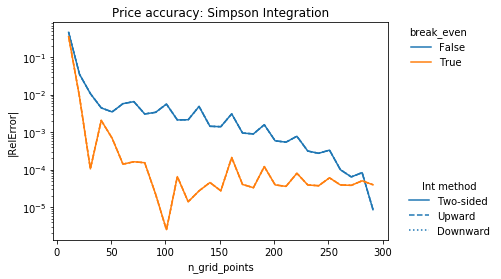

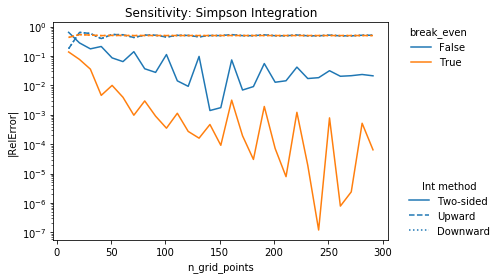

In [12]:
for i in [False,True]:
    plotRelativeError2(
        table_simpson,
        leg1='break_even',
        leg2=None,
        title='Simpson Integration',
        x_axis='n_grid_points',x_axis_label='n_grid_points',
        x_log_scale=False,
        sensitivity=i
    )

Plots for different $\lambda$s.

In [13]:
%%timeit -r 1
%%capture
table_simpson = compute_integration2_multiple(
    methods=[SimpsonIntegration],
    n_grid_points=[101],
    lambda_std_devs=[i for i in np.arange(0.5,10,0.5)], 
    hs=[10**(-10)],
    break_even=[False,True]
)

47.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


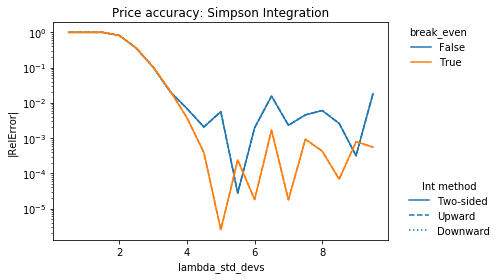

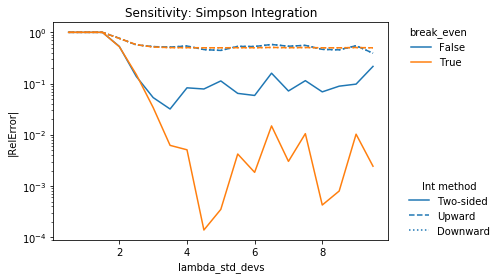

In [14]:
for i in [False,True]:
    plotRelativeError2(
        table_simpson,
        leg1='break_even',
        title='Simpson Integration',
        x_axis='lambda_std_devs',x_axis_label='lambda_std_devs',
        x_log_scale=False,
        sensitivity=i
    )

Plot for different number of grid points and $\lambda$s. 

In [15]:
%%timeit -r 1
%%capture
table_simpson = compute_integration2_multiple(
    methods=[SimpsonIntegration],
    n_grid_points=[i for i in range(11,301,10)],
    lambda_std_devs=[2.5,5,7.5,10], 
    hs = [10**(-10)],
    break_even=True
)

2min 54s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


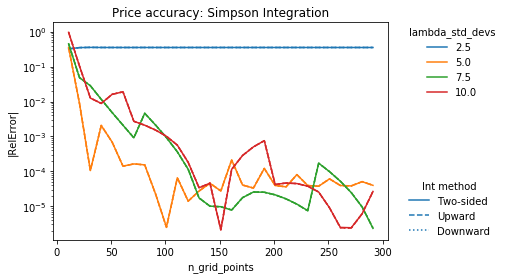

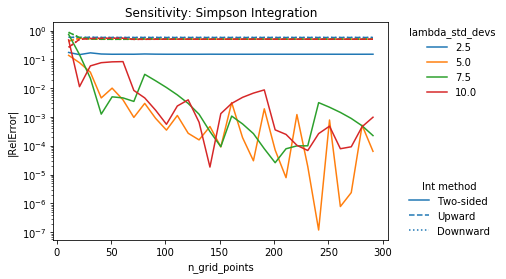

In [16]:
for i in [False,True]:
    plotRelativeError2(
        table_simpson,
        leg1='lambda_std_devs',
        title='Simpson Integration',
        x_axis='n_grid_points',x_axis_label='n_grid_points',
        x_log_scale=False,
        sensitivity=i
    )

### 6.2 (c) Cubic Spline

In [17]:
%%timeit -r 1
%%capture
table= compute_integration2_multiple(
    methods=[CubicSplineExactIntegration],
    n_grid_points=[101],
    lambda_std_devs=[5], 
    hs = [10**(-i) for i in range(3,18)],
    break_even=[False,True]
)

38.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


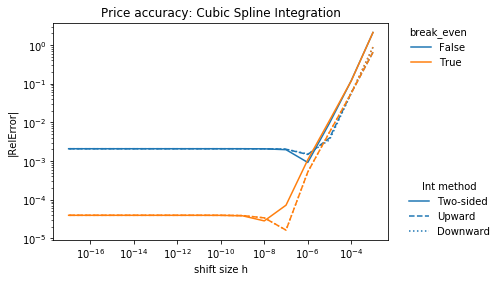

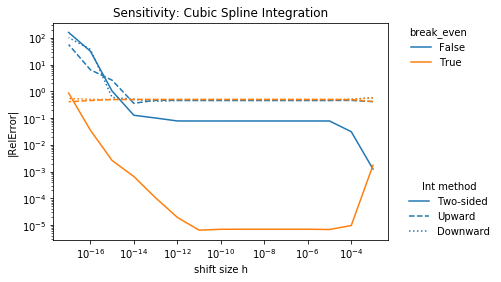

In [18]:
for i in [False,True]:
    plotRelativeError2(table,leg1 = 'break_even',title='Cubic Spline Integration',sensitivity=i)

Plot for different number of grid points:

In [19]:
%%timeit -r 1
%%capture
table = compute_integration2_multiple(
    methods=[CubicSplineExactIntegration],
    n_grid_points=[i for i in range(11,301,10)],
    lambda_std_devs=[5], 
    hs = [10**(-10)],
    break_even=[False,True]
)

1min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


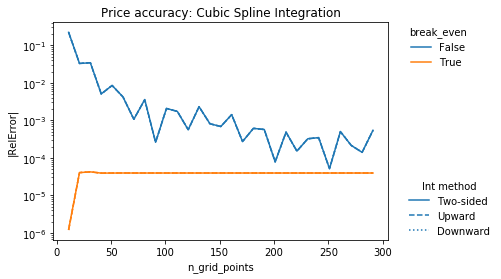

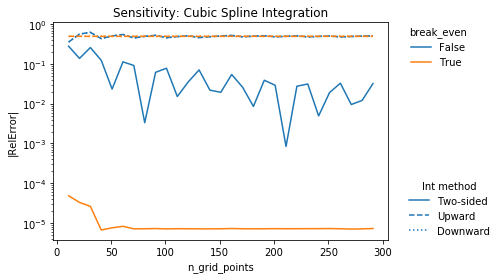

In [20]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='break_even',
        title='Cubic Spline Integration',
        x_axis='n_grid_points',x_axis_label='n_grid_points',
        x_log_scale=False,
        sensitivity=i
    )

Plots for different $\lambda$s.

In [21]:
%%timeit -r 1
%%capture
table = compute_integration2_multiple(
    methods=[CubicSplineExactIntegration],
    n_grid_points=[101],
    lambda_std_devs=[i for i in np.arange(0.5,10,0.5)], 
    hs = [10**(-10)],
    break_even=[False,True]
)

49.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


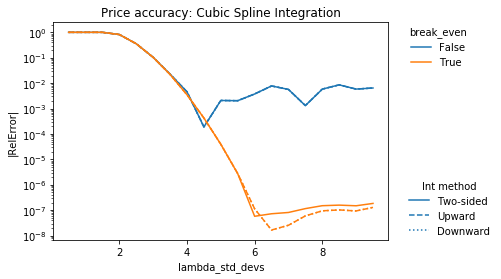

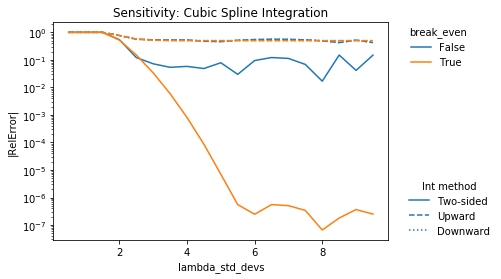

In [22]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='break_even',
        title='Cubic Spline Integration',
        x_axis='lambda_std_devs',x_axis_label='lambda_std_devs',
        x_log_scale=False,
        sensitivity=i
    )

plotRelativeError2(table,leg1 = 'break_even',title='Cubic Spline',sensitivity=)

In [23]:
%%timeit -r 1
%%capture
table = compute_integration2_multiple(
    methods=[CubicSplineExactIntegration],
    n_grid_points=[i for i in range(11,301,10)],
    lambda_std_devs=[5,7.5,10,20],
    hs = [10**(-10)],
    break_even=[True]
)

3min 5s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


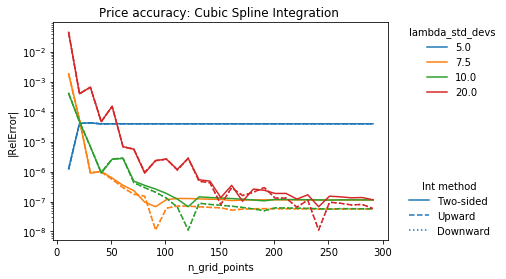

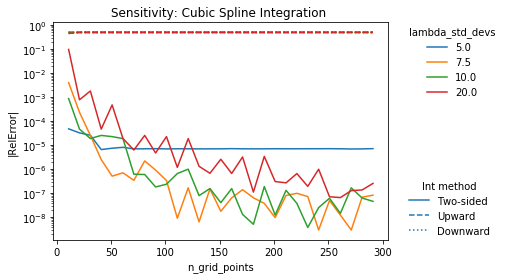

In [24]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='lambda_std_devs',
        title='Cubic Spline Integration ',
        x_axis='n_grid_points',x_axis_label='n_grid_points',
        x_log_scale=False,
        sensitivity=i
    )

### 6.2 (b) Hermite integration

In [25]:
%%timeit -r 1
%%capture
table = compute_integration2_multiple(
    methods=[HermiteIntegration],
    n_grid_points=[101],
    lambda_std_devs=[5], 
    hs = [10**(-i) for i in range(3,18)], 
    degree = [3],
    break_even=[False,True]
)

35.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


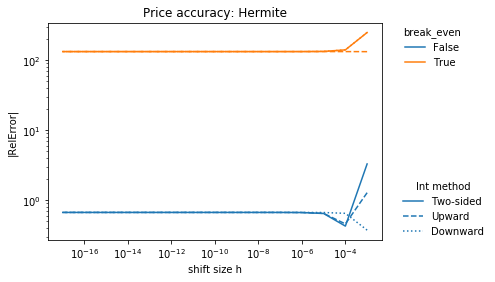

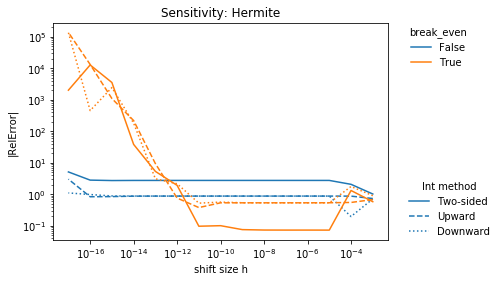

In [26]:
for i in [False,True]:
    plotRelativeError2(table,leg1 = 'break_even',title='Hermite',sensitivity=i)

Plot for different number of degrees:

In [27]:
%%timeit -r 1
%%capture
table,_ = compute_integration2_multiple(
    methods=[HermiteIntegration],
    n_grid_points=[101],
    lambda_std_devs=[5], 
    hs = [10**(-8)],
    degree=[i for i in range(1,101,2)],
    break_even=[False,True]
)

2min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


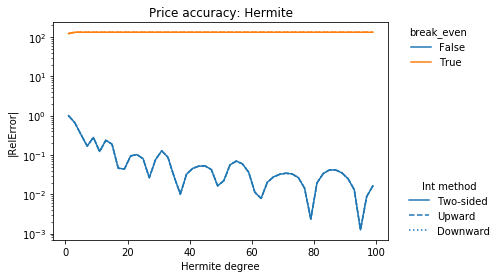

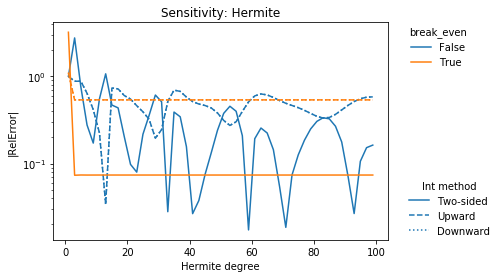

In [28]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='break_even',
        title='Hermite',
        x_axis='degree',x_axis_label='Hermite degree',
        x_log_scale=False,
        sensitivity=i
    )

Plot for different number of grid points and $\lambda$s.

In [9]:
%%timeit -r 1
%%capture
table = compute_integration2_multiple(
    methods=[CubicSplineExactIntegration],
    degree=[19],
    n_grid_points=[i for i in range(11,301,10)],
    lambda_std_devs=[2.5,5,7.5,10],
    hs = [10**(-10)],
    break_even=[False]
)

2min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


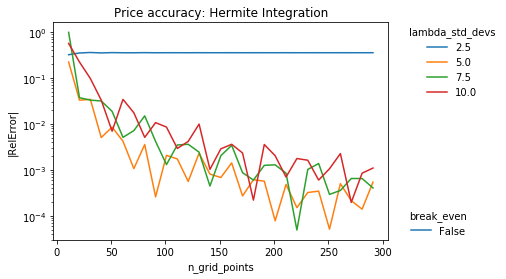

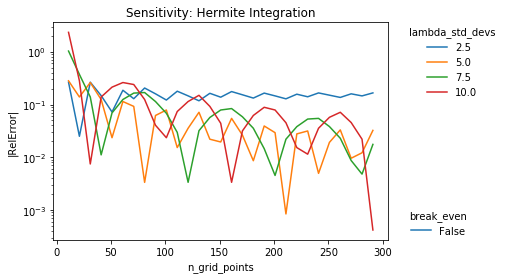

In [10]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='lambda_std_devs',
        leg2='break_even',
        title='Hermite Integration',
        integration_method='Two-sided',
        x_axis='n_grid_points',x_axis_label='n_grid_points',
        x_log_scale=False,
        sensitivity=i
    )

### 6.2 (d) Comparison of integration methods

Comparing the integration methods wrt shift parameter h.

In [31]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    methods = [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration],
    n_grid_points=[101],
    lambda_std_devs=[5],
    hs = [10**(-i) for i in range(3,18)],
    degree=[2,3],
    break_even=[False,True]
)

3min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


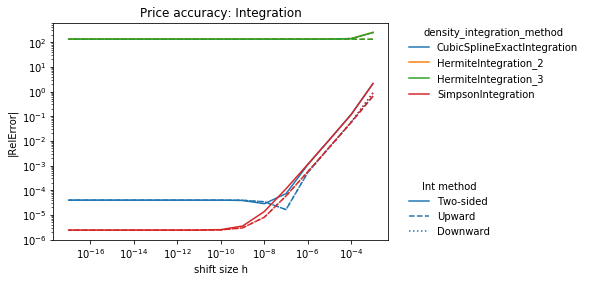

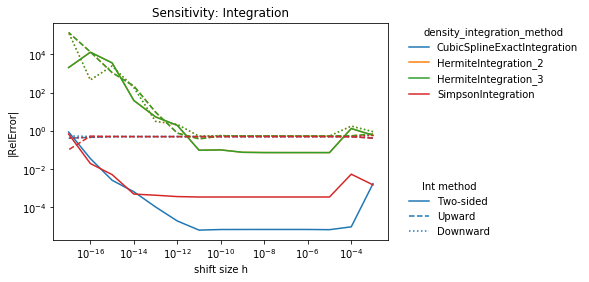

In [32]:
idx = table['density_integration_method'] == 'HermiteIntegration'
table.loc[idx,'density_integration_method'] = table.loc[idx,'density_integration_method'] + '_' + table.loc[idx,'degree'].map(str)
for i in [False,True]:
    plotRelativeError2(
        table.query('break_even==1'),
        leg1='density_integration_method',
        title='Integration',
        sensitivity=i
    )

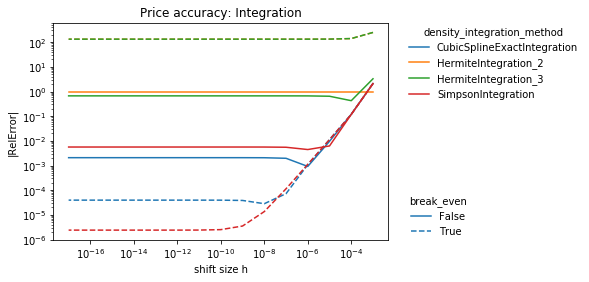

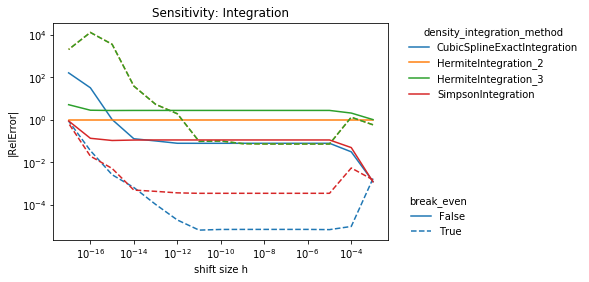

In [33]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='density_integration_method',
        leg2='break_even',
        title='Integration',
        integration_method='Two-sided',
        sensitivity=i
    )

In [34]:
time_table.round({'comp_time':2}).head()

,method,degree,comp_time
0,SimpsonIntegration,NaN,22.52
1,SimpsonIntegration,NaN,32.68
2,CubicSplineExactIntegration,NaN,37.85
3,CubicSplineExactIntegration,NaN,37.62
4,HermiteIntegration,2.0,19.19


Plot comparing number of grids and $\lambda$s.

In [35]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    methods = [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration],
    n_grid_points=[i for i in range(11,301,10)],
    lambda_std_devs=[2.5,5,10], hs = [10**(-8)],
    degree=[3],
    break_even=[True,False]
)

14min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


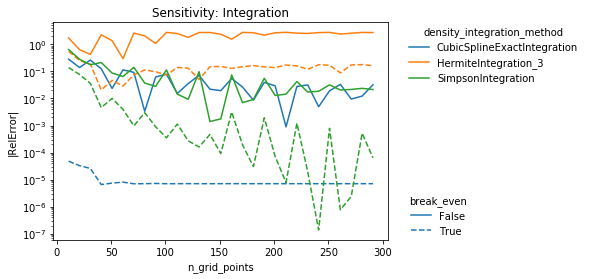

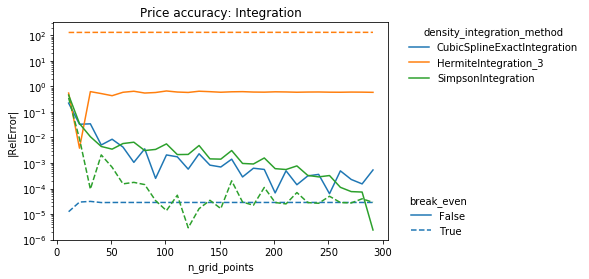

In [36]:
idx = table['density_integration_method'] == 'HermiteIntegration'
table.loc[idx,'density_integration_method'] = table.loc[idx,'density_integration_method'] + '_' + table.loc[idx,'degree'].map(str)
for i in [True,False]:
    plotRelativeError2(
        table.query('lambda_std_devs==5'),
        leg1='density_integration_method',
        leg2='break_even',
        title='Integration',
        x_axis='n_grid_points',x_axis_label='n_grid_points',
        integration_method='Two-sided',
        x_log_scale=False,
        sensitivity=i
    )

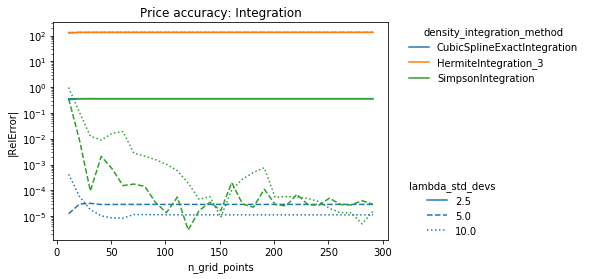

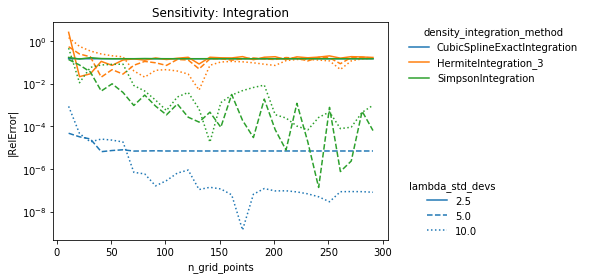

In [37]:
for i in [False,True]:
    plotRelativeError2(
        table.query('break_even==1'),
        leg1='density_integration_method',
        leg2='lambda_std_devs',
        title='Integration',
        x_axis='n_grid_points',x_axis_label='n_grid_points',
        integration_method='Two-sided',
        x_log_scale=False,
        sensitivity=i
    )

In [38]:
time_table.round({'comp_time':2}).head()

,method,degree,comp_time
0,SimpsonIntegration,NaN,0.77
1,SimpsonIntegration,NaN,0.92
2,SimpsonIntegration,NaN,1.40
3,SimpsonIntegration,NaN,1.22
4,SimpsonIntegration,NaN,0.88


### 6.3 (a) PDE Methods

Plot for different $\lambda$s.

In [11]:
%%timeit -r 1
%%capture
table = compute_integration2_multiple(
    methods=[PDESolver],
    lambda_std_devs=[2.5,5,10],
    break_even=[False]
)

1min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


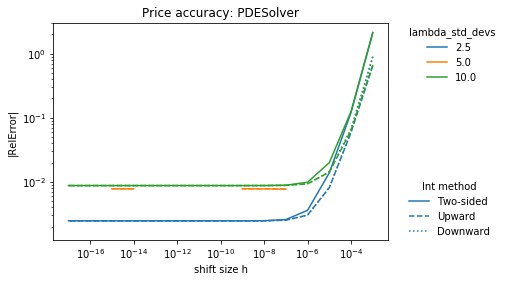

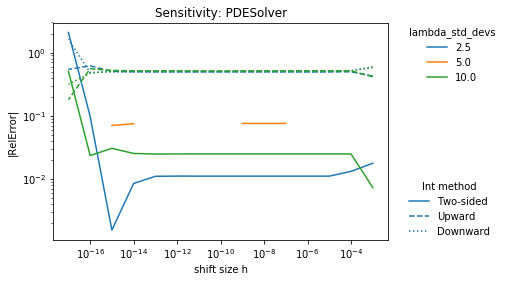

In [12]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='lambda_std_devs',
        title='PDESolver',
        sensitivity=i
    )

Plot for different number of grid points.

In [13]:
%%timeit -r 1
%%capture
table = compute_integration2_multiple(
    methods=[PDESolver],
    lambda_std_devs=[2.5,5,10],
    n_grid_points=[i for i in range(11,301,10)],
    hs=[10**(-10)],
    break_even=[False]
)

3min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


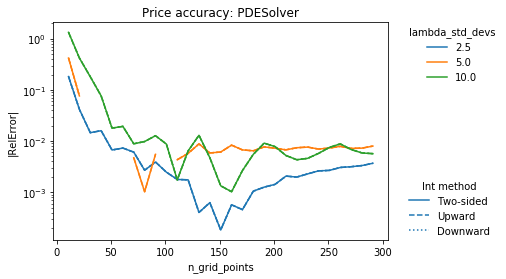

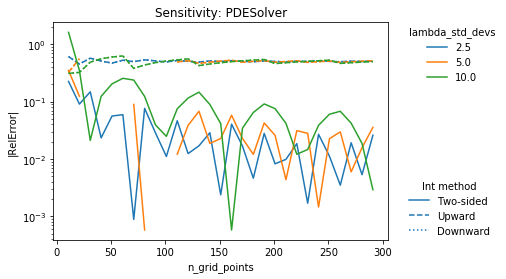

In [14]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='lambda_std_devs',
        title='PDESolver',
        x_axis='n_grid_points',x_axis_label='n_grid_points',
        x_log_scale=False,
        sensitivity=i
    )

### 6.3 (b)

Plot for different time step size and $\lambda$s.

In [9]:
timeStepSize_=[i/48 for i in range(1,8)]
timeStepSize_.extend([2/12,3/12,4/12,5/12,6/12,9/12,1,1.5,2])

In [10]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    methods=[PDESolver],
    lambda_std_devs=[2.5,5,10],
    n_grid_points=[151],
    hs=[10**(-10)],
    timeStepSize=timeStepSize_,
    break_even=[False],
)

1min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


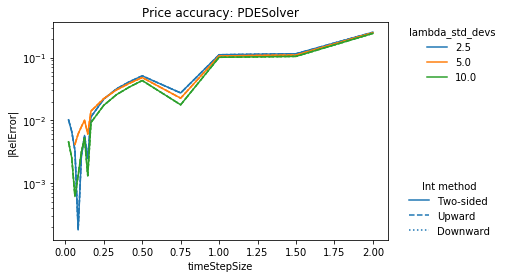

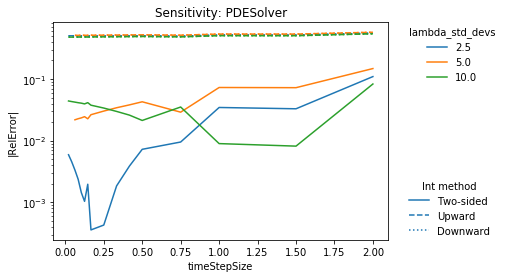

In [11]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='lambda_std_devs',
        title='PDESolver',
        x_axis='timeStepSize',x_axis_label='timeStepSize',
        x_log_scale=False,
        sensitivity=i
    )

Plot for different time step size and number of grid points.

In [12]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    methods=[PDESolver],
    lambda_std_devs=[2.5],
    n_grid_points=[51,101,201],
    hs=[10**(-10)],
    timeStepSize=timeStepSize_,
    break_even=[False]
)

1min 16s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


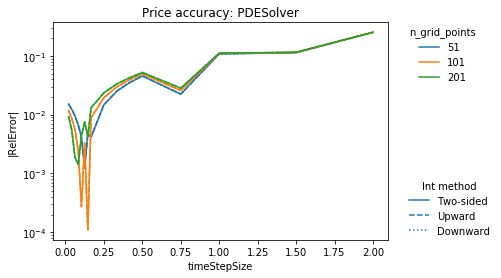

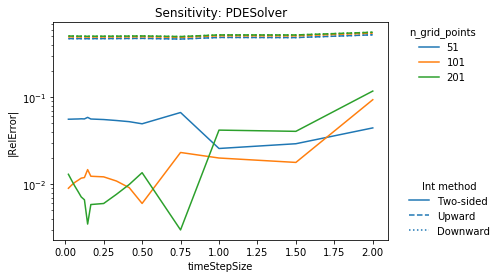

In [13]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='n_grid_points',
        title='PDESolver',
        x_axis='timeStepSize',x_axis_label='timeStepSize',
        x_log_scale=False,
        sensitivity=i
    )

### 6.3 (c)

Plot for different $\theta$ 

In [14]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    methods=[PDESolver],
    lambda_std_devs=[2.5,5],
    n_grid_points=[101],
    hs=[10**(-10)],
    theta=[i/10 for i in range(3,11,1)],
    break_even=[False]
)

25.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


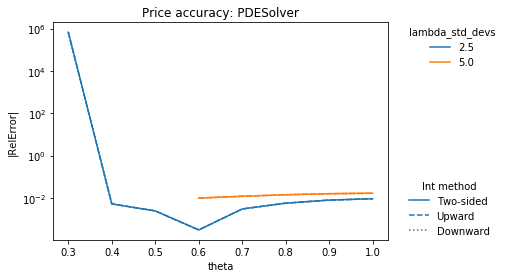

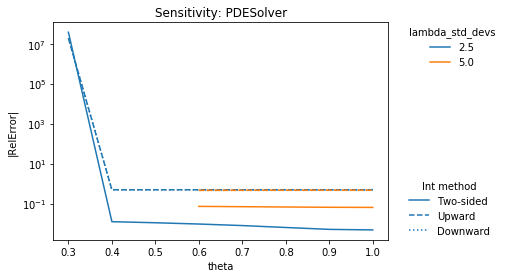

In [15]:
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='lambda_std_devs',
        title='PDESolver',
        x_axis='theta',x_axis_label='theta',
        x_log_scale=False,
        sensitivity=i
    )

### 6.3 (d)

Plot boundary condition versus grid size.

In [16]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    methods=[PDESolver],
    lambda_std_devs=[i for i in np.arange(2,10,1)],
    n_grid_points=[101],
    hs=[10**(-10)],
    break_even=[False],
    lambda0N=[None,0]
)

22.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


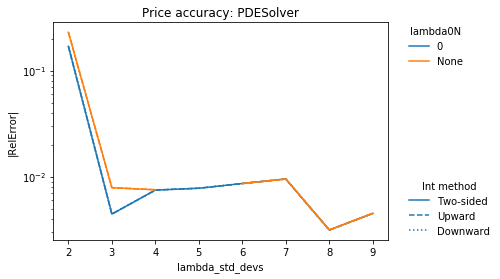

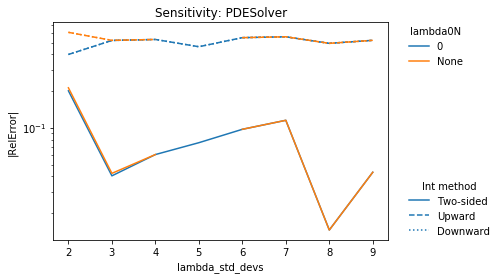

In [17]:
table['lambda0N'] = table['lambda0N'].map(str)
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='lambda0N',
        title='PDESolver',
        x_axis='lambda_std_devs',x_axis_label='lambda_std_devs',
        x_log_scale=False,
        sensitivity=i
    )

In [18]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    methods=[PDESolver],
    lambda_std_devs=[2.5,5],
    n_grid_points=[101],
    hs=[10**(-i) for i in range(3,18)],
    break_even=[False],
    lambda0N=[None,0]
)

1min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


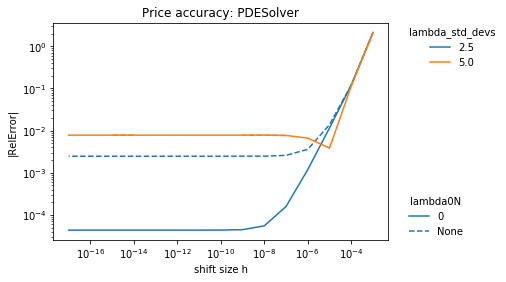

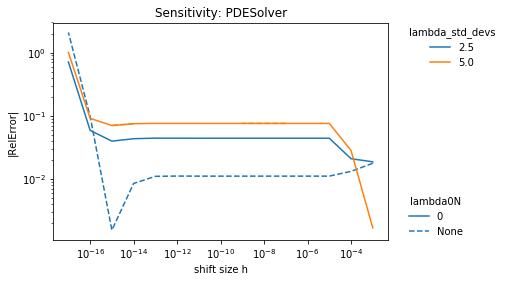

In [19]:
table['lambda0N'] = table['lambda0N'].map(str)
for i in [False,True]:
    plotRelativeError2(
        table,
        leg1='lambda_std_devs',
        leg2='lambda0N',
        title='PDESolver',
        integration_method = 'Two-sided',
        sensitivity=i
    )